In [1]:
import sys
import yaml

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

sys.path.append('../src')
sys.path.append('../../../utils')

from unet import Unet
from isbi_em_dataset import ISBIEMDataset

from eval_utils import evaluate_model, get_pixel_accuracy
from train_utils import Trainer, he_init, OptimizerFactory

2024-12-17 20:09:16.182410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734446356.199694   42078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734446356.205319   42078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 20:09:16.223652: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load config.
with open('../configs/train_pretrained_config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Load dataset.
transform = transforms.Compose([
    transforms.ToTensor(),
])
DATA_DIR = '/home/kramasamy/Code/projects/cnn/data/isbi_em_segmentation'
train_dataset = ISBIEMDataset(DATA_DIR, transform=transform, train=True)
test_dataset = ISBIEMDataset(DATA_DIR, transform=transform, train=False)

In [3]:
##Load model.
# Get dataset class frequency. 

In [4]:
import pickle as pkl
pretrain_unet_result = pkl.load(open('../checkpoints/pretrain_unet_results.pkl', 'rb'))
pretrained_unet = pretrain_unet_result['model'].unet

In [5]:
model = Unet()
model.apply(he_init)
model.load_state_dict(pretrained_unet.state_dict())

# Custom optimizer.
encoder_params = list(model.block1.parameters()) + \
                 list(model.block2.parameters()) + \
                 list(model.block3.parameters()) + \
                 list(model.block4.parameters()) + \
                 list(model.block5.parameters())

decoder_params = list(model.block6.parameters()) + \
                 list(model.block7.parameters()) + \
                 list(model.block8.parameters()) + \
                 list(model.block9.parameters()) + \
                 list(model.final_conv.parameters())

optimizer_factory = OptimizerFactory(config['optimizer'])
lr = config['optimizer']['params']['lr']
del config['optimizer']['params']['lr']
optimizer = optimizer_factory.get_optimizer([
    {'params': encoder_params, 'lr': lr * config['optimizer']['lr_damp_pretrained']},  
    {'params': decoder_params, 'lr': lr}   # Larger LR for decoder
])

In [6]:
# Load model.
torch.cuda.empty_cache()
model.to('cuda')
trainer = Trainer(model, train_dataset, config)
result = trainer.train(optimizer=optimizer, print_loss=True)

tensor([0.7794, 0.2206])
Get loss fn with weighted loss.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15, Loss: 0.7003124783436457


  7%|▋         | 1/15 [02:21<32:57, 141.26s/it]

Epoch 2/15, Loss: 0.3823384861151377


 13%|█▎        | 2/15 [05:45<38:37, 178.25s/it]

Epoch 3/15, Loss: 0.3617113411426544


 20%|██        | 3/15 [10:07<43:17, 216.44s/it]

Epoch 4/15, Loss: 0.33824067562818527


 27%|██▋       | 4/15 [14:31<43:09, 235.37s/it]

Epoch 5/15, Loss: 0.3227940971652667


 33%|███▎      | 5/15 [18:54<40:53, 245.38s/it]

Epoch 6/15, Loss: 0.31082764665285745


 40%|████      | 6/15 [23:13<37:30, 250.07s/it]

Epoch 7/15, Loss: 0.3113960246245066


 47%|████▋     | 7/15 [27:26<33:26, 250.81s/it]

Epoch 8/15, Loss: 0.3027216210961342


 53%|█████▎    | 8/15 [31:05<28:04, 240.68s/it]

Epoch 9/15, Loss: 0.29216754337151846


 60%|██████    | 9/15 [34:18<22:34, 225.71s/it]

Epoch 10/15, Loss: 0.28951140691836674


 67%|██████▋   | 10/15 [37:31<17:58, 215.80s/it]

Epoch 11/15, Loss: 0.2879475916425387


 73%|███████▎  | 11/15 [41:43<15:06, 226.74s/it]

Epoch 12/15, Loss: 0.2852658912539482


 80%|████████  | 12/15 [46:03<11:50, 236.82s/it]

Epoch 13/15, Loss: 0.27871674473086994


 87%|████████▋ | 13/15 [50:24<08:08, 244.39s/it]

Epoch 14/15, Loss: 0.2785674420495828


 93%|█████████▎| 14/15 [54:46<04:09, 249.54s/it]

Epoch 15/15, Loss: 0.2760184158881505


100%|██████████| 15/15 [59:06<00:00, 236.41s/it]


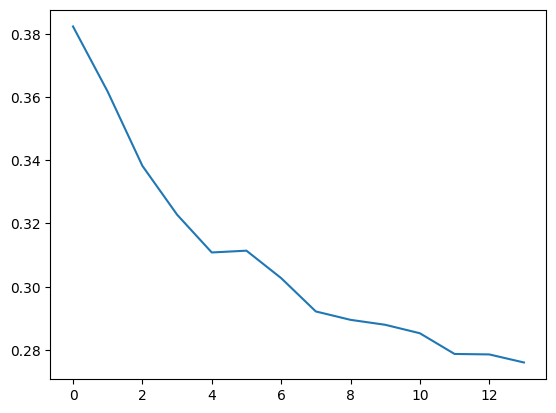

In [7]:
import matplotlib.pyplot as plt

plt.plot(result['loss_history'][1:])

In [8]:
torch.cuda.empty_cache()
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
y_pred_train, y_true_train = evaluate_model(model, train_loader)
y_pred_test, y_true_test = evaluate_model(model, test_loader)

In [9]:
print(get_pixel_accuracy(y_pred_train, y_true_train))
print(get_pixel_accuracy(y_pred_test, y_true_test))


87.87715148925781
87.28175354003906


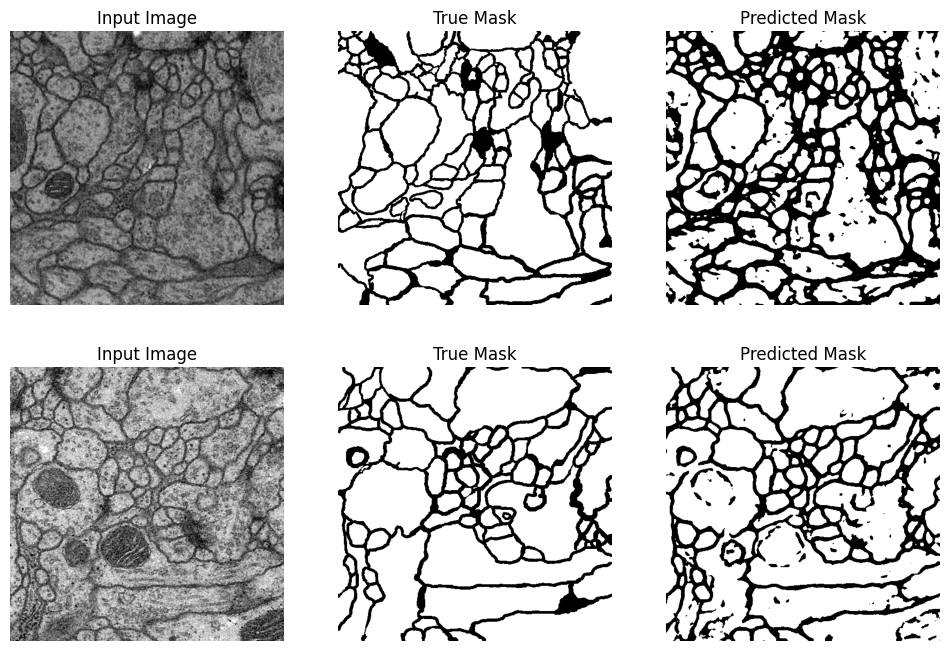

: 

In [10]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Subset

n = 2 # Number to sample to examine.

random_indices = random.sample(range(len(test_dataset)), n)
random_subset = Subset(train_dataset, random_indices)
random_test_dataloader = DataLoader(random_subset, batch_size=2)
y_pred_logits, y_true = evaluate_model(model, random_test_dataloader)


fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    img = random_subset[i][0]
    # Plot input image (assuming the image has 3 channels or grayscale)
    axes[i, 0].imshow(img.squeeze().to('cpu'), cmap='gray')
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis('off')

    # Plot true mask
    axes[i, 1].imshow(y_true[i].to('cpu'), cmap='gray')
    axes[i, 1].set_title("True Mask")
    axes[i, 1].axis('off')

    # Plot predicted mask
    y_probs = F.softmax(y_pred_logits[i], dim=0)
    y_pred = torch.argmax(y_probs, dim=0)
    axes[i, 2].imshow(y_pred.to('cpu'), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')